# Task 01: Introduction to Pytorch

## Introduction

The goal of this task is to get us thinking not just about training models, but about our *training pipelines*.

A neural network is a function, $f$, that accepts in data inputs, $\boldsymbol{X}$, and weights, $\boldsymbol{\Theta}$ that produces labels $\boldsymbol{\hat{y}}$,

$$
\boldsymbol{\hat{y}} = f(\Theta; \boldsymbol{X}).
$$

Meanwhile, a neural network training process, is itself a function, $g$, which accepts as input a dataset $x$, and for supervised algorithms a set of targets $y$, along with a set of parameters $\boldsymbol{\Omega}$ which define how the process is performed, and produces as output the weights of a neural network, $\boldsymbol{\Theta}$,

$$
\Theta = g(\boldsymbol{\Omega}; \boldsymbol{X}, \boldsymbol{y}).
$$

It is helpful to think of the training function, $g$, as a pipeline, composed of several training steps, which can include preprocessing, post processing, etc.

$$
g = g_N \circ\ \cdots\ \circ g_1.
$$

For example, $g_1$ might be a preprocessing step, then $g_2$ might be a training step, and $g_3$ might be a pruning step in a basic pipeline where data $(\boldsymbol{X}, \boldsymbol{y})$ goes in and weights $\boldsymbol{\Theta}$ come out.

We will learn to think of the training process this way by modifying some example code for a basic MNIST classification task. We begin with some imports.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from dataclasses import dataclass


## Task 01 - Part 1

Your first task is to:

* Add layer definitions to the following neural network class
* Define the forward pass

You can find starting architectures online. It is important to know there is no known theory to identify a best architecture *before* starting the problem. Trial and error (by iterative training and testing) is the only way to prove or disprove the utility of an architecture.

That said, recall some intuition about the way linear and nonlinear transforms work. We know we need a chain of both to have any hope of solving this problem. We also know that we need some depth, and cannot solve this problem by width alone.


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input: 1 channel (grayscale), Output: 32 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Input: 32 channels, Output: 64 channels
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with kernel size 2x2
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes (digits 0-9)
        
    def forward(self, x):
        # Forward pass through the network
        x = self.pool(F.relu(self.conv1(x)))  # Convolution + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolution + ReLU + Pooling
        
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 64 * 7 * 7)  # Flattening the tensor
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))  
        x = self.fc2(x)  # Output layer
        
        # Apply log softmax for compatibility with NLL loss
        return F.log_softmax(x, dim=1)  # Log-softmax output for NLL loss
        


def run_training_epoch(
    training_params, model, device, train_loader, optimizer, epoch
):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % training_params.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if training_params.dry_run:
                break


def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

## Helper Code: Training Pipeline

For this assignment, the training pipeline is defined for you. Notice the similarities to the mathematical description of a trainer we saw above.

In [10]:
@dataclass
class TrainingParameters:
    """Training parameters for a simple neural network trainer."""

    batch_size: int = 64
    test_batch_size: int = 1000
    epochs: int = 14
    lr: float = 1.0
    gamma: float = 0.7
    normalizer_mean = 0.1307
    normalizer_std = 0.3081
    no_cuda: bool = True  # Enable or disable CUDA
    no_mps: bool = True  # Enable or disable GPU on MacOS
    dry_run: bool = False
    seed: int = 1
    log_interval: int = 10
    save_model: bool = True


def configure_training_device(training_params):
    use_cuda = not training_params.no_cuda and torch.cuda.is_available()
    use_mps = not training_params.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(training_params.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {"batch_size": training_params.batch_size}
    test_kwargs = {"batch_size": training_params.test_batch_size}

    if use_cuda:
        cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    return device, train_kwargs, test_kwargs


def build_preprocessing_transform(training_params):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (training_params.normalizer_mean,),
                (training_params.normalizer_std,),
            ),
        ]
    )

    return transform


def build_data_loaders(train_kwargs, test_kwargs, transform):
    dataset1 = datasets.MNIST(
        "../data", train=True, download=True, transform=transform
    )
    dataset2 = datasets.MNIST("../data", train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    return train_loader, test_loader


def train(training_params, device, train_loader, test_loader):
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

    for epoch in range(1, training_params.epochs + 1):
        run_training_epoch(
            training_params, model, device, train_loader, optimizer, epoch
        )
        predict(model, device, test_loader)
        scheduler.step()

        if training_params.save_model:
            torch.save(model.state_dict(), "mnist_cnn.pt")

## Example: Execute a Training Pipeline

With our training steps defined in modular fashion, we can easily define and execute a training pipeline.

In [11]:
def execute_training_pipeline():
    training_params = TrainingParameters(epochs=1, dry_run=True)
    device, train_kwargs, test_kwargs = configure_training_device(
        training_params
    )
    transform = build_preprocessing_transform(training_params)
    train_loader, test_loader = build_data_loaders(
        train_kwargs, test_kwargs, transform
    )
    train(training_params, device, train_loader, test_loader)


execute_training_pipeline()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303561

Test set: Average loss: 2.2275, Accuracy: 1387/10000 (14%)



# Task 01 - Part 2: Explore Width

Using the example above, define a network with a single hidden layer.

Modify the trainer to store the train and test errors in a numpy vector.

Create a for loop over to iterate through a few different amounts of hidden neurons and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

(It should be hard to get good convergence here - this is part of the exercise.)

Training with hidden size: 10
Converged at epoch 3 for hidden size 10.
Training with hidden size: 20
Converged at epoch 5 for hidden size 20.
Training with hidden size: 50
Converged at epoch 4 for hidden size 50.
Training with hidden size: 100
Converged at epoch 2 for hidden size 100.
Training with hidden size: 200
Converged at epoch 2 for hidden size 200.


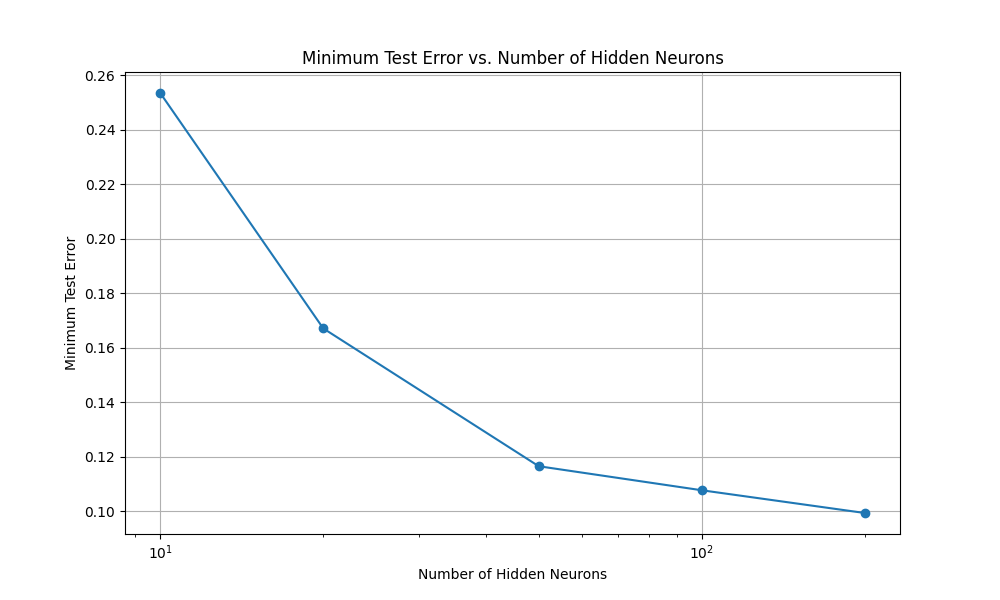

In [12]:
# Your code here
# Your code here
import matplotlib.pyplot as plt
# Define a single hidden layer network
class SingleHiddenLayerNet(nn.Module):
    def __init__(self, hidden_size):
        super(SingleHiddenLayerNet, self).__init__()
        self.fc1 = nn.Linear(784, hidden_size)  # Input layer (784) to hidden layer
        self.fc2 = nn.Linear(hidden_size, 10)    # Hidden layer to output layer (10 classes)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = F.relu(self.fc1(x))  # ReLU activation for hidden layer
        x = self.fc2(x)  # Output layer
        return F.log_softmax(x, dim=1)  # Log-softmax output

# Function to run a training epoch
def run_training_epoch(training_params, model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    average_loss = total_loss / len(train_loader)
    return average_loss

# Function to evaluate the model
def evaluate_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    average_loss = test_loss / len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    return average_loss, accuracy

# Function to train with a specific hidden size
def train_with_hidden_size(hidden_size, training_params, device, train_loader, test_loader):
    model = SingleHiddenLayerNet(hidden_size).to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)

    train_errors = []
    test_errors = []
    
    for epoch in range(training_params.epochs):
        train_loss = run_training_epoch(training_params, model, device, train_loader, optimizer, epoch)
        test_loss, _ = evaluate_model(model, device, test_loader)
        
        train_errors.append(train_loss)
        test_errors.append(test_loss)
        
        # Check for convergence (when error stops decreasing)
        if epoch > 1 and test_errors[-1] >= test_errors[-2]:
            print(f"Converged at epoch {epoch} for hidden size {hidden_size}.")
            break
    
    min_test_error = min(test_errors)
    return min_test_error


# Function to explore hidden sizes
def explore_hidden_sizes():
    hidden_sizes = [10, 20, 50, 100, 200]  # Different numbers of hidden neurons
    min_errors = []

    training_params = TrainingParameters(epochs=50, dry_run=False)  # Set epochs for proper training
    device, train_kwargs, test_kwargs = configure_training_device(training_params)
    transform = build_preprocessing_transform(training_params)
    train_loader, test_loader = build_data_loaders(train_kwargs, test_kwargs, transform)

    for hidden_size in hidden_sizes:
        print(f"Training with hidden size: {hidden_size}")
        min_error = train_with_hidden_size(hidden_size, training_params, device, train_loader, test_loader)
        min_errors.append(min_error)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(hidden_sizes, min_errors, marker='o')
    plt.title("Minimum Test Error vs. Number of Hidden Neurons")
    plt.xlabel("Number of Hidden Neurons")
    plt.ylabel("Minimum Test Error")
    plt.xscale('log')  # Log scale for better visualization if needed
    plt.grid()
    

# Execute the exploration of hidden sizes
explore_hidden_sizes()


Task 01 - Part 3: Explore Depth

Now using the example above, define several networks with increasing numbers of hidden layers (either convolutional or fully connected).

As above, create a for loop over to iterate through a few different depths and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

This example should converge much better.

In [6]:
# Your code here

# Define a fully connected neural network with variable depth
class DeepFullyConnectedNet(nn.Module):
    def __init__(self, layer_sizes):
        super(DeepFullyConnectedNet, self).__init__()
        layers = []
        input_size = 784  # Input layer size (MNIST images are 28x28)

        for size in layer_sizes:
            layers.append(nn.Linear(input_size, size))
            layers.append(nn.ReLU())  # Add ReLU activation after each layer
            input_size = size  # Update input size for the next layer

        layers.append(nn.Linear(input_size, 10))  # Output layer (10 classes)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        return F.log_softmax(self.model(x), dim=1)  # Log-softmax output




# Function to train with a specific network depth
def train_with_depth(layer_sizes, training_params, device, train_loader, test_loader):
    model = DeepFullyConnectedNet(layer_sizes).to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)

    train_errors = []
    test_errors = []
    
    for epoch in range(training_params.epochs):
        train_loss = run_training_epoch(training_params, model, device, train_loader, optimizer, epoch)
        test_loss, _ = evaluate_model(model, device, test_loader)
        
        train_errors.append(train_loss)
        test_errors.append(test_loss)
        
        # Check for convergence (when error stops decreasing)
        if epoch > 1 and test_errors[-1] >= test_errors[-2]:
            print(f"Converged at epoch {epoch} for depth {len(layer_sizes)}.")
            break
    
    min_test_error = min(test_errors)
    return min_test_error


# Function to explore network depths
def explore_network_depths():
    # Different architectures with increasing numbers of hidden layers
    depths = [
        [128],            # 1 hidden layer
        [128, 128],      # 2 hidden layers
        [128, 128, 128], # 3 hidden layers
        [128, 128, 128, 128], # 4 hidden layers
        [128, 128, 128, 128, 128]  # 5 hidden layers
    ]
    min_errors = []

    training_params = TrainingParameters(epochs=1, dry_run=False)  # Set epochs for proper training
    device, train_kwargs, test_kwargs = configure_training_device(training_params)
    transform = build_preprocessing_transform(training_params)
    train_loader, test_loader = build_data_loaders(train_kwargs, test_kwargs, transform)

    for layer_sizes in depths:
        min_error = train_with_depth(layer_sizes, training_params, device, train_loader, test_loader)
        min_errors.append(min_error)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(depths) + 1), min_errors, marker='o')
    plt.title("Minimum Test Error vs. Number of Hidden Layers")
    plt.xlabel("Number of Hidden Layers")
    plt.ylabel("Minimum Test Error")
    plt.xticks(range(1, len(depths) + 1))
    plt.grid()
    plt.show()

# Execute the exploration of network depths
explore_network_depths()

